# Lane Detection

Experiment with lane detection (own lane, lane to left if any)

https://www.youtube.com/playlist?list=PLS1QulWo1RIa7D1O6skqDQ-JZ1GGHKK-K

https://www.youtube.com/watch?v=yvfI4p6Wyvk

https://medium.com/analytics-vidhya/building-a-lane-detection-system-f7a727c6694

https://github.com/Arun-purakkatt/medium_repo/blob/main/road_lane_detection%20(1).py


## Load image and apply mask

(1080, 1920, 3)


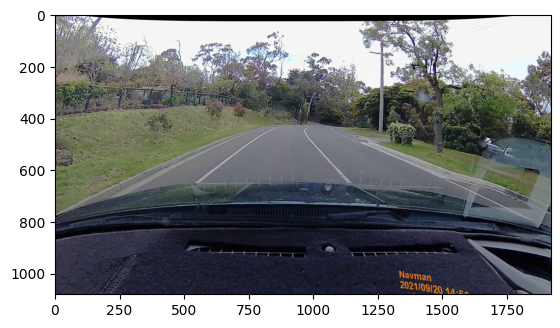

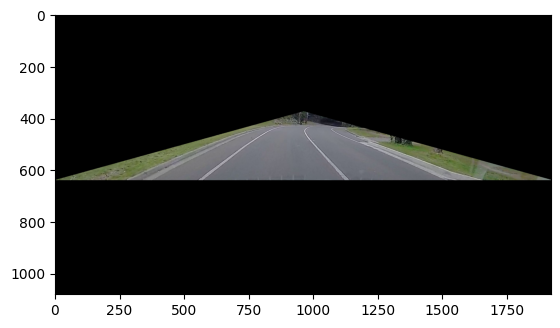

In [1]:
import os
import sys
import matplotlib.pylab as plt
import cv2
import numpy as np

module_path_root = os.path.abspath(os.pardir)
if module_path_root not in sys.path:
    sys.path.append(module_path_root)
    
#sample_file = os.path.join(os.pardir, 'data_sources', 'sample_dashcam_lanes.png')
sample_file = os.path.join(module_path_root, 'data_sources', 'dashcam_samples', 'corrected_ram_01_02160.png')

original_image = cv2.imread(sample_file)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

print(original_image.shape)
height = original_image.shape[0]
width = original_image.shape[1]

region_of_interest_vertices = [
    (0, 640),
    (width/2, 375),
    (width, 640)
]

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    channel_count = img.shape[2]
    match_mask_color = (255,) * channel_count
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
      
cropped_image = region_of_interest(original_image, np.array([region_of_interest_vertices],np.int32))

plt.imshow(original_image)
plt.show()

plt.imshow(cropped_image)
plt.show()

## Apply Canny Edge Detection

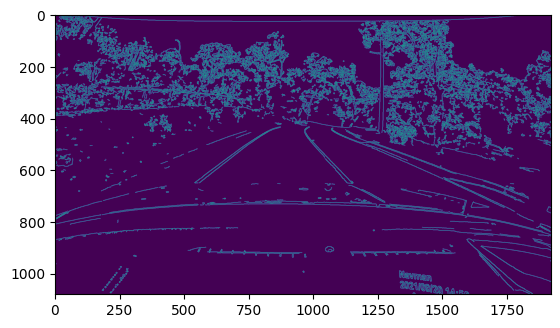

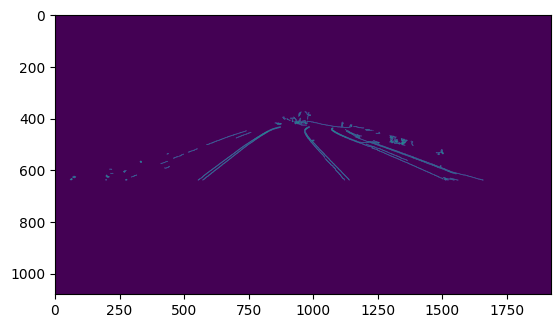

In [2]:
# Convert image to greyscale
# We want to use Canny edge detection FIRST, before cropping
# If we crop first, then the margins of the crop will be artificially detected as edges!
grey_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    match_mask_color = 255
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

blur_image = cv2.GaussianBlur(grey_image, (5, 5), 0)

canny_image = cv2.Canny(blur_image, 100, 200)

cropped_image = region_of_interest(canny_image, np.array([region_of_interest_vertices],np.int32))

plt.imshow(canny_image)
plt.show()

plt.imshow(cropped_image)
plt.show()

## Apply Hough Line Transform

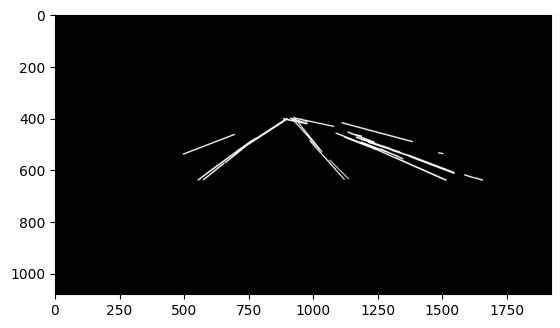

In [3]:
lines = cv2.HoughLinesP(
    cropped_image, 
    rho           = 2, 
    theta         = np.pi/60, # 60, 180
    threshold     = 100, #160, 100
    lines         = np.array([]), 
    minLineLength = 10, #10, 100
    maxLineGap    = 50 #100, 5
)

def draw_lines(img, lines):
    img = np.copy(img)
    
    line_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 255, 255), thickness=3)
    
    #img = cv2.addWeighted(img, 0.8, line_image, 1, 0.0)
    #return img
    return line_image

image_with_lines = draw_lines(original_image, lines)
    
plt.imshow(image_with_lines)
plt.show()    

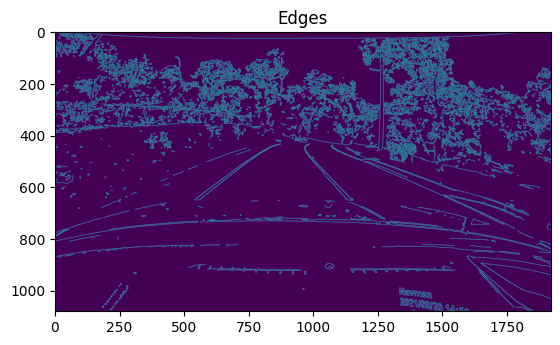

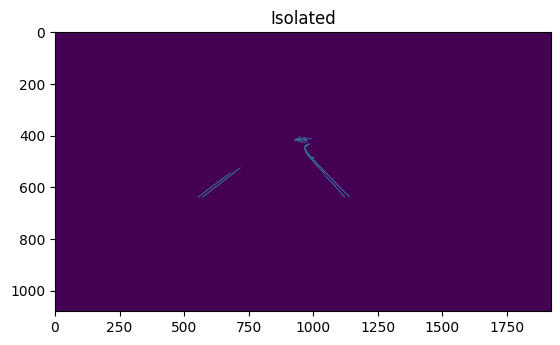

Left:  [(-0.8018867924528318, 1098.9150943396237), (-0.7307692307692307, 1042.4615384615383)]
Right: [(0.999999999999999, -497.999999999999), (1.1130434782608716, -606.2695652173937), (0.9999999999999978, -499.99999999999767), (1.2290076335877875, -728.1221374045814)]
display lines: [[ -13 1080  762  486]
 [1532 1080  984  486]]


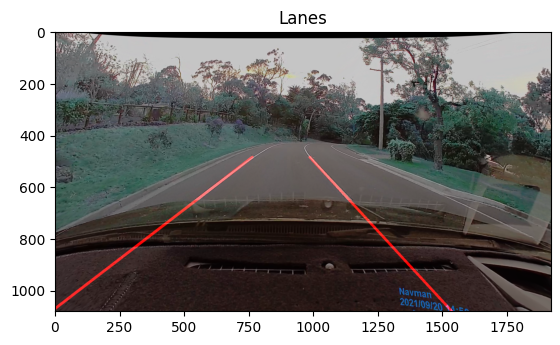

In [4]:
# https://medium.com/analytics-vidhya/building-a-lane-detection-system-f7a727c6694

import cv2
import matplotlib.pyplot as plt
import numpy as np

image_path = sample_file
image1 = cv2.imread(image_path)
plt.imshow(image1)

def grey(image):
  #convert to grayscale
    image = np.asarray(image)
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

  #Apply Gaussian Blur --> Reduce noise and smoothen image
def gauss(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

  #outline the strongest gradients in the image --> this is where lines in the image are
def canny(image):
    edges = cv2.Canny(image,50,150)
    return edges

def region(image, triangle):
    height, width = image.shape
    #isolate the gradients that correspond to the lane lines
    # from "triangle" parameter
    
    #create a black image with the same dimensions as original image
    mask = np.zeros_like(image)
    #create a mask (triangle that isolates the region of interest in our image)
    mask = cv2.fillPoly(mask, triangle, 255)
    mask = cv2.bitwise_and(image, mask)
    return mask

def display_lines(image, lines):
    print('display lines: ' + str(lines))
    lines_image = np.zeros_like(image)
    #make sure array isn't empty
    if lines is not None:
        for idx, line in enumerate(lines):
            if line is not None:
                x1, y1, x2, y2 = line
                #draw lines on a black image
                if idx <= 1:
                    color = (255, 0, 0)
                else:
                    color = (0, 255, 0)
                cv2.line(lines_image, (x1, y1), (x2, y2), color, 10)
    return lines_image

def average(image, lines, limit):
    left = []
    right = []

    if lines is not None:
      for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        #fit line to points, return slope and y-int
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        y_int = parameters[1]
        #lines on the right have positive slope, and lines on the left have neg slope
        if slope < 0:
            left.append((slope, y_int))
        else:
            right.append((slope, y_int))
    
    print('Left:  ' + str(left))
    print('Right: ' + str(right))
    
    #takes average among all the columns (column0: slope, column1: y_int)
    if len(right) > 0:
        right_avg = np.average(right, axis=0)
        right_line, right_slope, right_int = make_points(image, right_avg, limit)
    else:
        right_avg   = None
        right_line   = None
        right_slope = None
        right_int   = None
        
    if len(left) > 0:
        left_avg = np.average(left, axis=0)
        left_line, left_slope, left_int = make_points(image, left_avg, limit)
    else:
        left_avg   = None
        left_line  = None
        left_slope = None
        left_int   = None
                
    return np.array([left_line, right_line]), left_slope, left_int, right_slope, right_int
   
    
def make_points(image, average, limit):
    if average is None:
        return None
    
    slope, y_int = average
    y1 = image.shape[0]
    #how long we want our lines to be --> 3/5 the size of the image
    y2 = int(y1 * limit)
    #determine algebraically
    x1 = int((y1 - y_int) // slope)
    x2 = int((y2 - y_int) // slope)
    return np.array([x1, y1, x2, y2]), slope, y_int



'''##### DETECTING lane lines in image ######'''


copy = np.copy(image1)

initial_region = np.array([
    [(500, 640), (int(width/2), 400), (width-500, 640)]
])

isolated = region(canny_image, initial_region)

plt.imshow(canny_image)
plt.title('Edges')
plt.show()

plt.imshow(isolated)
plt.title('Isolated')
plt.show()

#DRAWING LINES: (order of params) --> region of interest, bin size (P, theta), min intersections needed, placeholder array, 
#lines = cv2.HoughLinesP(isolated, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)
lines = cv2.HoughLinesP(isolated, 2, np.pi/60, 100, np.array([]), minLineLength=10, maxLineGap=50)

averaged_lines1, left_slope1, left_int1, right_slope1, right_int1 = average(copy, lines, 9/20)
black_lines = display_lines(copy, averaged_lines1)
#taking wighted sum of original image and lane lines image
lanes = cv2.addWeighted(copy, 0.8, black_lines, 1, 1)

plt.imshow(lanes)
plt.title('Lanes')
plt.show()


# Second pass to find the next lane over

Move the area of interest further to the left.  How far?  To the left of the left lane already identified

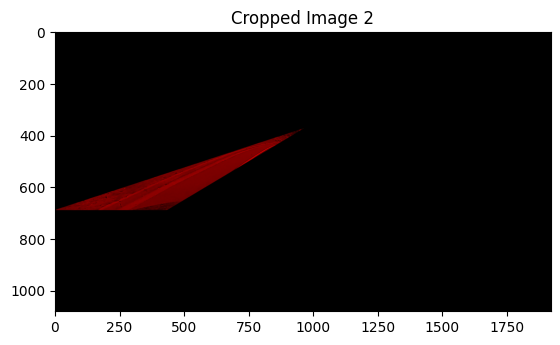

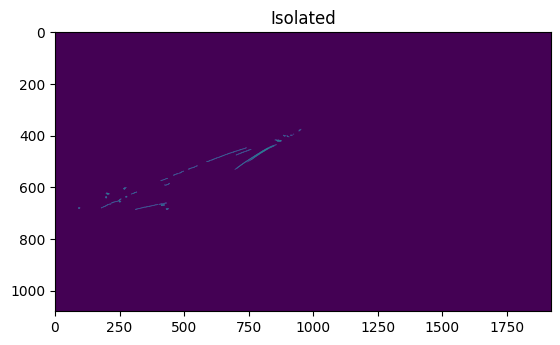

Left:  [(-0.6533333333333319, 985.4799999999988), (-0.3834951456310677, 730.1456310679611), (-0.6506849315068495, 988.0136986301369), (-0.4366197183098607, 756.5070422535216), (-0.38461538461538514, 746.6153846153852)]
Right: []
display lines: [[ -13 1080  762  486]
 [1532 1080  984  486]
 [-476 1080  708  486]]


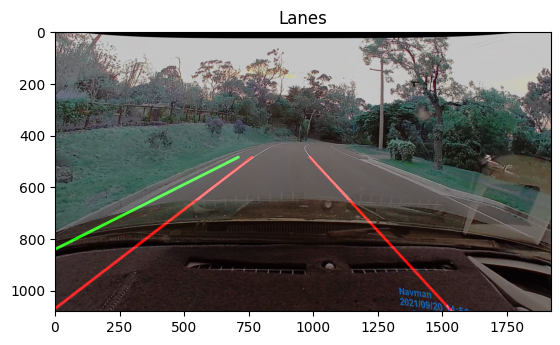

In [5]:
left_region = np.array([
    [(0, 640), (int(width/2), 375), (int(round((640 - left_int1) / left_slope1)), 640)]
])

left_region = np.array([
    [(0, 690), (int(width/2), 375), (int(round((690 - left_int1 + 50) / left_slope1)), 690)]
])



original_image = cv2.imread(sample_file)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

cropped_image2 = region_of_interest(original_image, np.array(left_region,np.int32))

plt.imshow(cropped_image2)
plt.title('Cropped Image 2')
plt.show()


isolated = region(canny_image, left_region)

plt.imshow(isolated)
plt.title('Isolated')
plt.show()

#DRAWING LINES: (order of params) --> region of interest, bin size (P, theta), min intersections needed, placeholder array, 
lines = cv2.HoughLinesP(isolated, 2, np.pi/60, 100, np.array([]), minLineLength=10, maxLineGap=100)
averaged_lines2, left_slope2, left_int2, right_slope2, right_int2  = average(copy, lines, 9/20)
averaged_lines = np.array([averaged_lines1[0], averaged_lines1[1], averaged_lines2[0]])
black_lines2 = display_lines(copy, averaged_lines)
#taking wighted sum of original image and lane lines image
lanes = cv2.addWeighted(copy, 0.8, black_lines2, 1, 1)

plt.imshow(lanes)
plt.title('Lanes')
plt.show()



In [6]:
cv2.imwrite(os.path.join(os.pardir, 'data_sources', 'lane_demo.png'), lanes)

True

In [7]:
horizontal = 640

green = (horizontal - left_int2) / left_slope2
red1  = (horizontal - left_int1) / left_slope1
red2  = (horizontal - right_int1) / right_slope1

print(green, left_slope2, left_int2)
print(red1, left_slope1, left_int1)
print(red2, right_slope1, right_int1)

401.30038989200614 -0.501749702679299 841.3523513134008
562.015625 -0.7663280116110313 1070.688316400581
1126.7466864384755 1.085512777962164 -583.097925655493


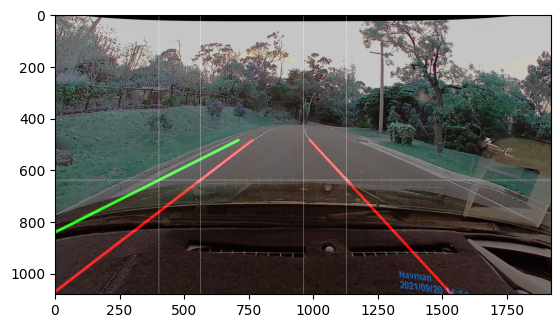

In [12]:
cv2.line(lanes, (0, 640), (width, 640), (255, 255, 255), thickness=1)
cv2.line(lanes, (int(width/2), 0), (int(width/2), height), (255, 255, 255), thickness=1)
cv2.line(lanes, (int(green), 0), (int(green), 1080), (255, 255, 255), thickness=1)
cv2.line(lanes, (int(red1), 0), (int(red1), 1080), (255, 255, 255), thickness=1)
cv2.line(lanes, (int(red2), 0), (int(red2), 1080), (255, 255, 255), thickness=1)

plt.imshow(lanes)
plt.show()


In [14]:
green_offset = abs((width/2) - green)
red1_offset  = abs((width/2) - red1)
red2_offset  = abs((width/2) - red2)

print(int(width/2))
print(green_offset, green)
print(red1_offset, red1)
print(red2_offset, red2)

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
import pickle

model_filename_poly = os.path.join(module_path_root, 'models', 'distance_poly.csv')
model_filename_pol  = os.path.join(module_path_root, 'models', 'distance_pol.csv')

loaded_poly = pickle.load(open(model_filename_poly, 'rb'))
loaded_pol  = pickle.load(open(model_filename_pol,  'rb'))


predictions = loaded_pol.predict(loaded_poly.fit_transform([[green_offset], [red1_offset], [red2_offset]]))

print(predictions)

960
558.6996101079939 401.30038989200614
397.984375 562.015625
166.74668643847554 1126.7466864384755
[299.07935176 209.33408527  89.83089638]


In [10]:
print ('Bike lane width: {0:.2f}'.format(predictions[0] - predictions[1]))

Bike lane width: 89.75


In [16]:
def loaded_predict(X):
    return loaded_pol.predict(loaded_poly.fit_transform([[X]]))

print(loaded_predict(559))
print(loaded_predict(398))

[299.25954086]
[209.34232005]
